# 5th axis alignment

In the double wire configuration, the wires might be misaligned with regard to the beam. That is, in IP1 (vertical crossing), the two wires will be centered in the vertical plane, but might be misaligned on the horizontal plane. Starting from the multipolar expansion:


$$\begin{aligned} K_{N_n} + iK_{S_n} = -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \frac{n!}{\left(r_w e^{i\phi_w}\right)^{n+1}}  \end{aligned}$$

and assuming that the two wires are at an angle $\pm\phi_w$ with regard to the beam, one finds:

$$\begin{aligned} K_{N_n} + iK_{S_n} &= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{e^{-i(n+1)\phi_w} + e^{i(n+1)\phi_w}}{r_w^{n+1}} \right]n!\\
\sum_n \frac{K_{N_n} + iK_{S_n}}{n!} &= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\overbrace{\frac{2\cos(\phi_w)}{r_w}}^{\text{Dipole}}
+ \overbrace{\frac{2\cos(2\phi_w)}{r_w^2}}^{\text{Quad.}}
+ \overbrace{\frac{2\cos(3\phi_w)}{r_w^3}}^{\text{Sext.}}
+ \overbrace{\frac{2\cos(4\phi_w)}{r_w^4}}^{\text{Octu.}}
+\dots\right]\end{aligned}$$

In the case where $\pm \phi_w = \pm \pi/2$, the odd multipoles are cancelled out, but this is not the case otherwise. The tune shift from the quadrupolar and octupolar contribution is :

$$\begin{aligned}\Delta Q_x (J_x, J_y) &= \delta Q_{1,x} + \delta Q_{3,x}(J_x,J_y)\\
&= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{1}{4\pi} \frac{2\cos(2\phi_w)}{r_w^2} \beta_x + \frac{3}{8\pi}\frac{2\cos(4\phi_w)}{r_w^4}\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\right]\\
&= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{8\pi^2} \left[ \frac{2\cos(2\phi_w)}{r_w^2} \beta_x + \frac{2\cos(4\phi_w)}{r_w^4} \frac{3}{2}\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\right]\end{aligned}$$


For the benefit of the Fit, let's rewrite the expected tune shift for on-axis particles as:

$$\Delta Q_x = -\left(\frac{\mu_0 L}{8\pi^2}\frac{ \beta_x}{B\rho}\right) \left[\frac{2\cos(2\phi_w)}{r_w^2}\right]  \cdot I = -\left(\frac{\mu_0 L}{8\pi^2}\frac{ \beta_x}{B\rho}\right)A\cdot I$$

where:
$$A = \frac{2\cos(2\phi_w)}{r_w^2} = \frac{2(x_w^2-y_w^2)}{(x_w^2+y_w^2)^2}$$

### Python implementation

In [2]:
import numpy as np
import Backend.Constants as cst

#=========================================
# Fitting function
#=========================================
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

def dQxdQy(I, xw , yw , betx, bety, Jx = 0 , Jy = 0 ,E = 450e9,L=1):
    rw,phiw = cart2pol(xw, yw)
    
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*(I*L)/(Brho*8*np.pi**2)
    
    quad = 2*np.cos(2*phiw)/rw**2
    octu = 2*np.cos(4*phiw)/rw**4 * (3/2)
    
    dQx  = Q0*( 1*quad*betx + octu*(betx**2*Jx - 2*betx*bety*Jy))
    dQy  = Q0*(-1*quad*bety + octu*(bety**2*Jy - 2*bety*betx*Jx))
    
    return dQx,dQy

def dQxfit(I,A,betx,E = 450e9,L=1):
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*L*betx/(Brho*8*np.pi**2)
    return Q0*A*I

def dQyfit(I,A,bety,E = 450e9,L=1):
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*L*bety/(Brho*8*np.pi**2)
    return -Q0*A*I

def extractOffset(A,xw=None,yw=None):
    
    if yw is not None:
        pref = np.sqrt(1-4*A*yw**2)/A
        return np.sqrt(-pref + 1/A - yw**2)#,np.sqrt(pref + 1/A - yw**2))
    
    if xw is not None:
        pref = np.sqrt(4*A*xw**2+1)/A
        return np.sqrt(pref - 1/A - xw**2)#(np.sqrt(-pref - 1/A - xw**2),)
    
#==========================================


## Reference exemple

In [ ]:
#%matplotlib widget

In [48]:
%matplotlib inline

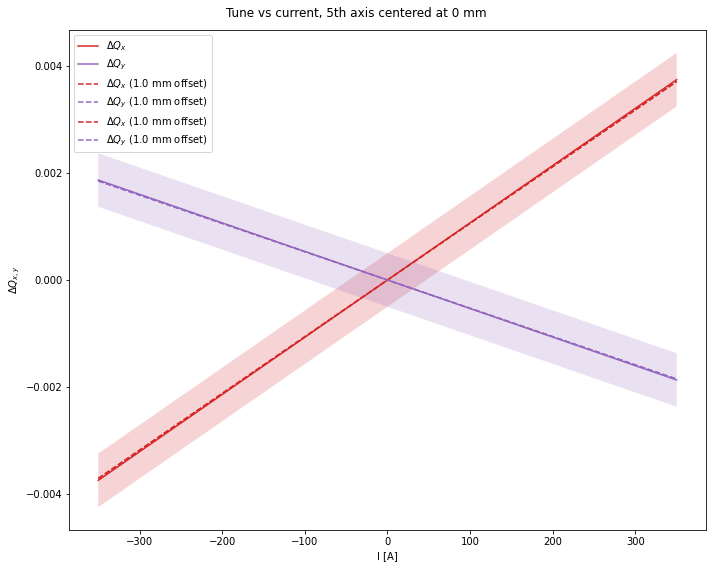

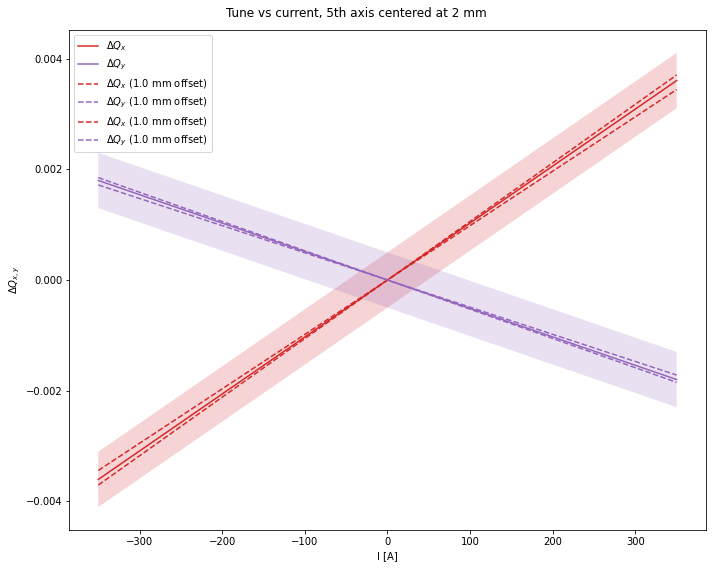

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make sure this import is after pandas
import Backend.Constants as cst
import Backend.NXCALS as nx
import twissExtractor



# From measurements
#=====================
tuneNoise = 5e-4  # -> 2*std() found in measurements
betx,bety = 163.3798836266144 , 81.5488800490455

gap    = 15e-3
offset = 1e-3

# Plotting reference

for center in [0e-3,2e-3]:

    I_vec = np.linspace(-350,350,100)
    Qx_ref,Qy_ref = dQxdQy(I_vec,xw = center,yw = gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)


    plt.figure(figsize=(10,8))
    plt.suptitle(f'Tune vs current, 5th axis centered at {center/1e-3:.0f} mm')
    plt.fill_between(I_vec,Qx_ref+tuneNoise,Qx_ref-tuneNoise,color='C3',alpha=0.2,edgecolor='none')
    plt.plot(I_vec,Qx_ref,color='C3',label=r'$\Delta Q_x$')


    plt.fill_between(I_vec,Qy_ref+tuneNoise,Qy_ref-tuneNoise,color='C4',alpha=0.2,edgecolor='none')
    plt.plot(I_vec,Qy_ref,color='C4',label=r'$\Delta Q_y$')


    for sign in [+1,-1]:
        Qx_off,Qy_off = dQxdQy(I_vec,xw = center + sign*offset,yw = gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)
        plt.plot(I_vec,Qx_off,'--',color='C3',label=r'$\Delta Q_x$'+f' ({offset/1e-3:.1f} mm offset)')
        plt.plot(I_vec,Qy_off,'--',color='C4',label=r'$\Delta Q_y$'+f' ({offset/1e-3:.1f} mm offset)')

    plt.legend()
    #plt.ylim([-0.0075,0.0075])
    plt.xlabel('I [A]')
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.tight_layout()



## Slope sensitivity? 


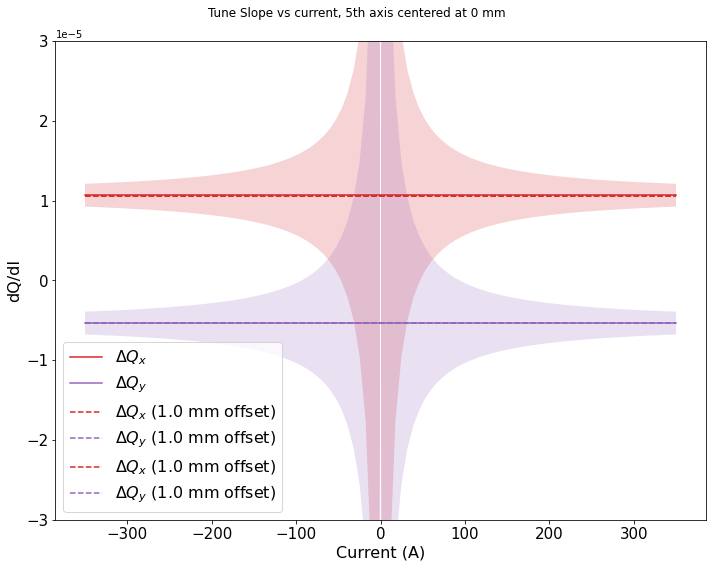

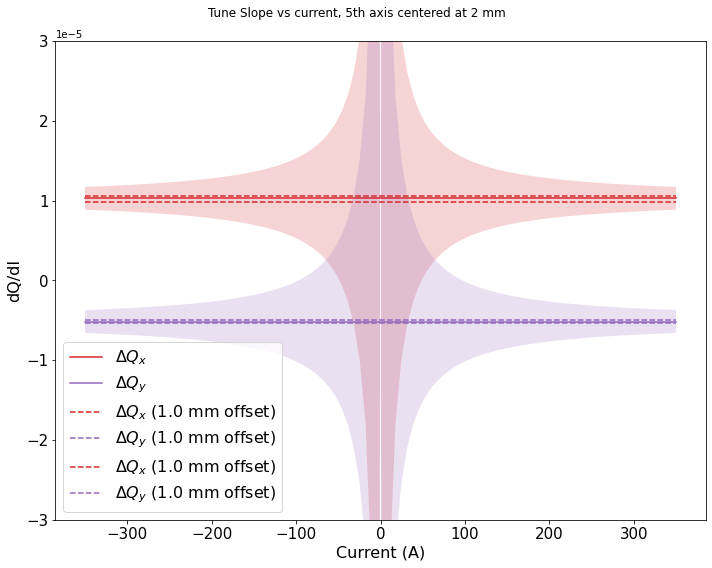

In [132]:

for center in [0e-3,2e-3]:

    I_vec = np.linspace(-350,350,100)
    Qx_ref,Qy_ref = dQxdQy(I_vec,xw = center,yw = gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)


    plt.figure(figsize=(10,8))
    plt.suptitle(f'Tune Slope vs current, 5th axis centered at {center/1e-3:.0f} mm')
    plt.fill_between(I_vec,(Qx_ref+tuneNoise)/I_vec,(Qx_ref-tuneNoise)/I_vec,color='C3',alpha=0.2,edgecolor='none')
    plt.plot(I_vec,Qx_ref/I_vec,color='C3',label=r'$\Delta Q_x$')


    plt.fill_between(I_vec,(Qy_ref+tuneNoise)/I_vec,(Qy_ref-tuneNoise)/I_vec,color='C4',alpha=0.2,edgecolor='none')
    plt.plot(I_vec,Qy_ref/I_vec,color='C4',label=r'$\Delta Q_y$')


    for sign in [+1,-1]:
        Qx_off,Qy_off = dQxdQy(I_vec,xw = center + sign*offset,yw = gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)
        plt.plot(I_vec,Qx_off/I_vec,'--',color='C3',label=r'$\Delta Q_x$'+f' ({offset/1e-3:.1f} mm offset)')
        plt.plot(I_vec,Qy_off/I_vec,'--',color='C4',label=r'$\Delta Q_y$'+f' ({offset/1e-3:.1f} mm offset)')

        
    plt.ylim([-3e-5,3e-5])
    
    
    plt.legend(fontsize=16)
    plt.xlabel('Current (A)',fontsize=16)
    plt.ylabel(f'dQ/dI',fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    plt.tight_layout()


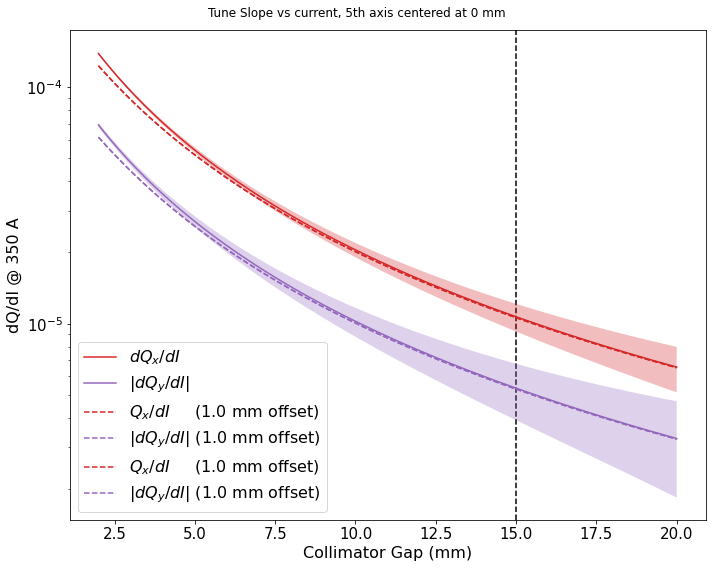

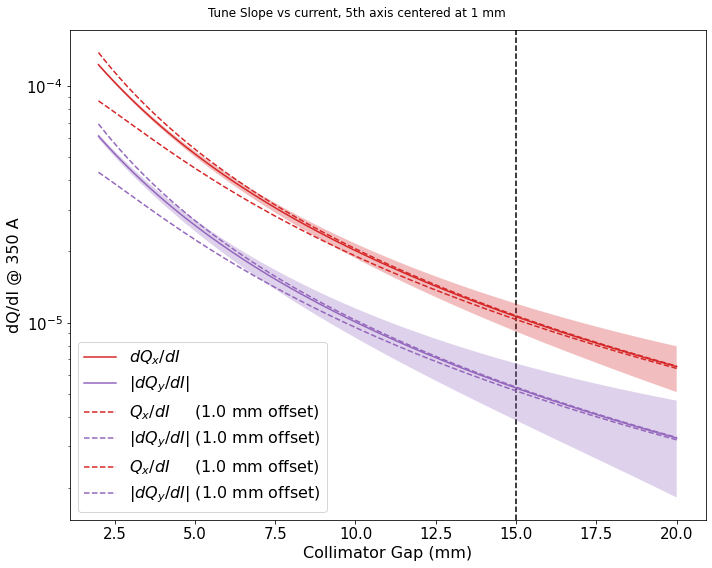

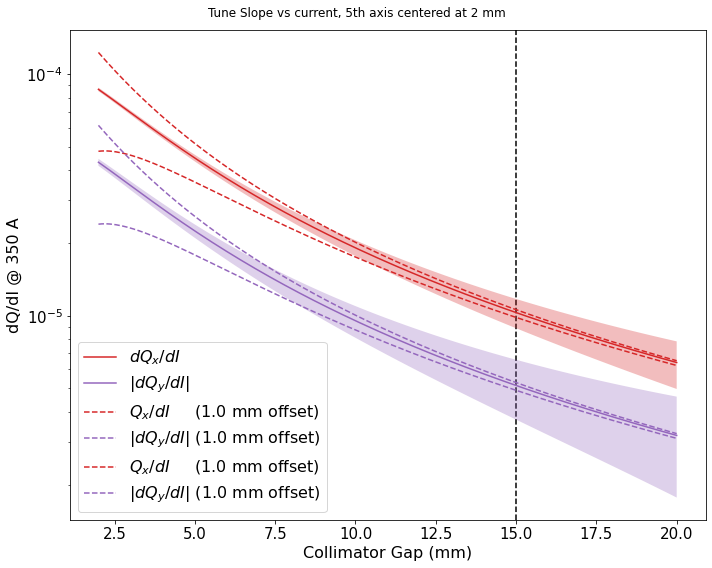

In [124]:
gaps    = np.linspace(2e-3,20e-3,200)
probe_I = 350

offset = 1e-3
for center in [0e-3,1e-3,2e-3]:
    
    
    SQx_ref,SQy_ref = [],[]
    SQx_off,SQy_off = {1:[],-1:[]},{1:[],-1:[]}
    
    
    # Computing for different gap values
    #==========================
    for _gap in gaps:
        _DQx,_DQy = dQxdQy(probe_I,xw = center,yw = _gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)
        SQx_ref.append(_DQx/probe_I)
        SQy_ref.append(_DQy/probe_I)
        
        for sign in [+1,-1]:
            _DQx,_DQy = dQxdQy(probe_I,xw = center + sign*offset,yw = _gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)
            SQx_off[sign].append(_DQx/probe_I)
            SQy_off[sign].append(_DQy/probe_I)
            
    SQx_ref = np.array(SQx_ref)
    SQy_ref = np.abs(np.array(SQy_ref))
    for sign in [+1,-1]:
        SQx_off[sign] = np.array(SQx_off[sign])
        SQy_off[sign] = np.abs(np.array(SQy_off[sign]))
    #==========================
    
    # Plotting
    plt.figure(figsize=(10,8))
    plt.suptitle(f'Tune Slope vs current, 5th axis centered at {center/1e-3:.0f} mm')
    
    plt.fill_between(gaps/1e-3,SQx_ref+tuneNoise/probe_I,SQx_ref-tuneNoise/probe_I,color='C3',alpha=0.3,edgecolor='none')
    plt.plot(gaps/1e-3,SQx_ref,color='C3',label=r'$dQ_x/dI$')
    
    plt.fill_between(gaps/1e-3,SQy_ref+tuneNoise/probe_I,SQy_ref-tuneNoise/probe_I,color='C4',alpha=0.3,edgecolor='none')
    plt.plot(gaps/1e-3,SQy_ref,color='C4',label=r'$\left|dQ_y/dI\right|$')
    
    for sign in [+1,-1]:
        plt.plot(gaps/1e-3,SQx_off[sign],'--',color='C3',label=r'$Q_x/dI$'+f'     ({offset/1e-3:.1f} mm offset)')
        plt.plot(gaps/1e-3,SQy_off[sign],'--',color='C4',label=r'$\left|dQ_y/dI\right|$'+f' ({offset/1e-3:.1f} mm offset)')
    
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.legend(fontsize=16)
    
    plt.xlabel('Collimator Gap (mm)',fontsize=16)
    plt.ylabel(f'dQ/dI @ {probe_I} A',fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.axvline(15,color='k',ls='--',zorder=-1)
    plt.tight_layout()

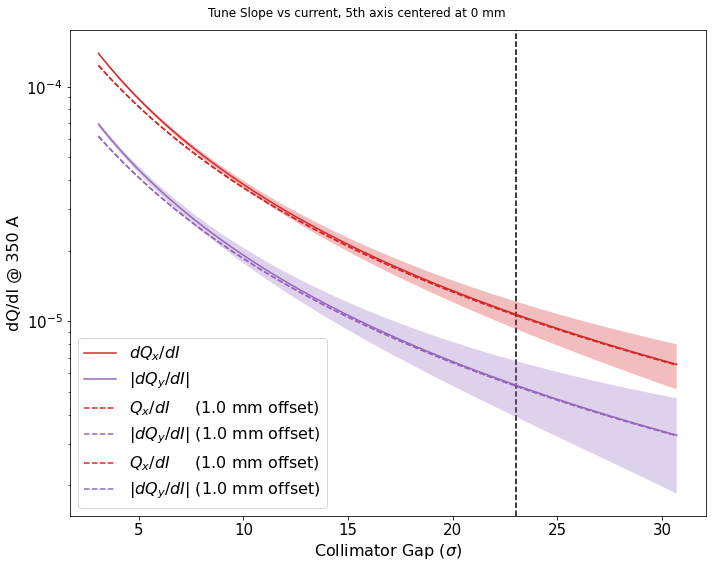

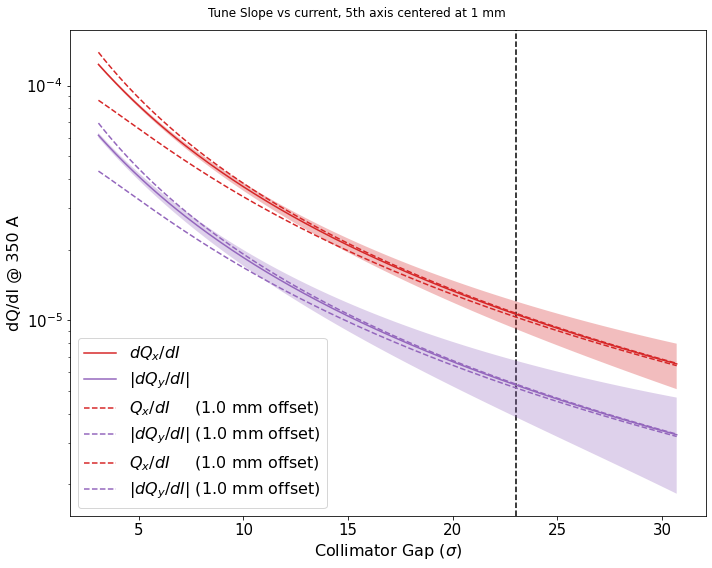

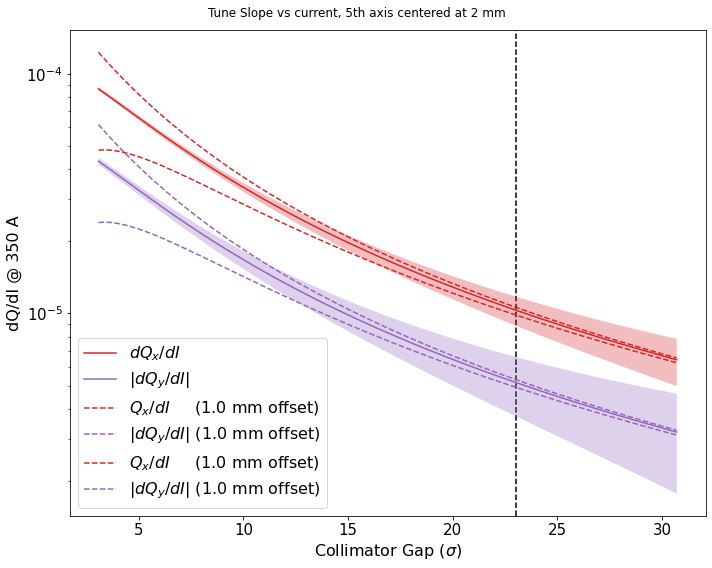

In [130]:
gaps    = np.linspace(2e-3,20e-3,200)
probe_I = 350
sigy  = np.sqrt(bety*2.5e-6/(1+450e9/cst.m_p_eV))
offset = 1e-3
for center in [0e-3,1e-3,2e-3]:
    
    
    SQx_ref,SQy_ref = [],[]
    SQx_off,SQy_off = {1:[],-1:[]},{1:[],-1:[]}
    
    
    # Computing for different gap values
    #==========================
    for _gap in gaps:
        _DQx,_DQy = dQxdQy(probe_I,xw = center,yw = _gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)
        SQx_ref.append(_DQx/probe_I)
        SQy_ref.append(_DQy/probe_I)
        
        for sign in [+1,-1]:
            _DQx,_DQy = dQxdQy(probe_I,xw = center + sign*offset,yw = _gap+3e-3, betx=betx,bety=bety, E = 450e9,L=1)
            SQx_off[sign].append(_DQx/probe_I)
            SQy_off[sign].append(_DQy/probe_I)
            
    SQx_ref = np.array(SQx_ref)
    SQy_ref = np.abs(np.array(SQy_ref))
    for sign in [+1,-1]:
        SQx_off[sign] = np.array(SQx_off[sign])
        SQy_off[sign] = np.abs(np.array(SQy_off[sign]))
    #==========================
    
    # Plotting
    plt.figure(figsize=(10,8))
    plt.suptitle(f'Tune Slope vs current, 5th axis centered at {center/1e-3:.0f} mm')
    
    plt.fill_between(gaps/sigy,SQx_ref+tuneNoise/probe_I,SQx_ref-tuneNoise/probe_I,color='C3',alpha=0.3,edgecolor='none')
    plt.plot(gaps/sigy,SQx_ref,color='C3',label=r'$dQ_x/dI$')
    
    plt.fill_between(gaps/sigy,SQy_ref+tuneNoise/probe_I,SQy_ref-tuneNoise/probe_I,color='C4',alpha=0.3,edgecolor='none')
    plt.plot(gaps/sigy,SQy_ref,color='C4',label=r'$\left|dQ_y/dI\right|$')
    
    for sign in [+1,-1]:
        plt.plot(gaps/sigy,SQx_off[sign],'--',color='C3',label=r'$Q_x/dI$'+f'     ({offset/1e-3:.1f} mm offset)')
        plt.plot(gaps/sigy,SQy_off[sign],'--',color='C4',label=r'$\left|dQ_y/dI\right|$'+f' ({offset/1e-3:.1f} mm offset)')
    
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.legend(fontsize=16)
    
    plt.xlabel(r'Collimator Gap ($\sigma$)',fontsize=16)
    plt.ylabel(f'dQ/dI @ {probe_I} A',fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.axvline(15e-3/sigy,color='k',ls='--',zorder=-1)
    plt.tight_layout()